# EE4375: Fourth Lab Session: Second Order Finite Element Method for the Poisson Equation on the Unit Interval

## Import Packages  

In [1]:
using LinearAlgebra 
using SparseArrays 
using StructArrays
using StaticArrays
using StaticRanges

using IterativeSolvers
using Preconditioners

using BenchmarkTools
using Profile
using ProfileView

using Plots 

## Section 1: Introduction  
More later. 

## Section 2: One-Dimensional Mesh Generation 

In [2]:
# struct to hold a single mesh element
# all the members of the struct should be concrete type 
struct Element
  p1::Float64          # coordinate left-most node
  p2::Float64          # coordinate right-most node
  p3::Float64          # coordinate middle node
  e1::Int64            # global index left-most node
  e2::Int64            # global index right-most node
  e3::Int64            # global index middle node 
  area::Float64        # area of the element
  dofPerElement::Int64 # number of degrees of freedom per element   
end

# struct to hold entire mesh
struct Mesh
  nnodes::Int64
  nelements::Int64 
  # specify one-dimensional array of elements as an array of structs. 
  # we worry about using structArray (if as all) later. 
  Elements::Array{Element,1}
  bndNodeIds::Vector{Int64}   
  Nodes::Vector{Float64}
end 

In [3]:
# function to generate a mesh on the interval 0 <= x <= 1.   
# we limit the type of input to be Int64 
function genMesh(nelements::Int64)::Mesh
    h = 1/nelements 
    nnodes = 2*nelements+1 #..observe deviation way from first order elements 
    dofs = 3 
    x = Vector{Float64}(0:h:1)    
    # what does the undef do here? 
    Elements = Array{Element,1}(undef,nelements)
    duplicatedNodes = zeros(Float64,dofs*nelements)
    Nodes = zeros(Float64,nnodes)
    for i in 1:nelements
        xmid = (x[i] + x[i+1])/2 
        # Elements[i] = Element(x[i],x[i+1],xmid,i,i+1,nelements+1+i,x[i+1]-x[i],dofPerElement)
        Elements[i] = Element(x[i],xmid,x[i+1],2*i-1,2*i,2*i+1,x[i+1]-x[i],dofs)
        duplicatedNodes[dofs*(i-1)+1:dofs*i] .= (x[i],x[i+1],xmid)
    end
    Nodes = sort!(unique!(duplicatedNodes))          
    mesh = Mesh(nnodes,nelements,Elements,[1,nelements+1],Nodes)     
    return mesh;
end 

genMesh (generic function with 1 method)

In [4]:
# test function for correctness of output 
mesh = genMesh(4)
display(mesh)
#display(sort(unique!(mesh.Nodes)))

Mesh(9, 4, Element[Element(0.0, 0.125, 0.25, 1, 2, 3, 0.25, 3), Element(0.25, 0.375, 0.5, 3, 4, 5, 0.25, 3), Element(0.5, 0.625, 0.75, 5, 6, 7, 0.25, 3), Element(0.75, 0.875, 1.0, 7, 8, 9, 0.25, 3)], [1, 5], [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0])

In [5]:
# test function for type stability 
# the text under Local @3 in orange font is considered to be harmless 
#@code_warntype genMesh(4);

In [6]:
# test function for number of allocations and CPU time
# observe how the number of memory allocations only depends midly on the mesh size 
@time genMesh(10);
@time genMesh(100);
@time genMesh(1000);
@time genMesh(10000);

  0.000014 seconds (12 allocations: 2.578 KiB)
  0.000026 seconds (18 allocations: 24.453 KiB)
  0.000094 seconds (24 allocations: 159.062 KiB)
  0.000832 seconds (36 allocations: 1.820 MiB)


In [7]:
#@code_lowered generateMesh(10)

## Section 3: Linear System Assembly 

### Section 1.3: Assemble Stiffness Matrix 
What follows is ugly, but works. 

In [8]:
function genLocStiffMat(element::Element)
    area  = element.area
    dofs  = element.dofPerElement
    dofs2 = dofs^2 
    v     = SVector(element.e1, element.e2, element.e3)
    Iloc  = SVector(v[1], v[1], v[1], v[2], v[2], v[2], v[3], v[3], v[3]) 
    Jloc  = SVector(v[1], v[2], v[3], v[1], v[2], v[3], v[1], v[2], v[3])
    Aloc  = SVector(7, -8, 1, -8, 16, -8, 1, -8, 7) 
    Aloc  = SVector(Aloc./(3*area))
    return Iloc, Jloc, Aloc
end

# generate global stiffness matrix 
function genStiffMat(mesh::Mesh)
    
    #..recover number of elements  
    nelements = mesh.nelements
    dofs      = mesh.Elements[1].dofPerElement; 
    dofs2     = dofs^2
    
    #..preallocate the memory for local matrix contributions 
    Avalues = zeros(Float64,dofs2*nelements)
    I = zeros(Int64,length(Avalues))
    J = zeros(Int64,length(Avalues))
    
    for i = 1:nelements #..loop over number of elements..
        element = mesh.Elements[i]
        Iloc, Jloc, Aloc = genLocStiffMat(element) 
        irng = mrange(dofs2*(i-1)+1,dofs2*i) 
        I[irng] .= Iloc 
        J[irng] .= Jloc 
        Avalues[irng] .= Aloc         
    end
        
    A = sparse(I,J,Avalues)
   
    return A; 
end

genStiffMat (generic function with 1 method)

In [9]:
mesh = genMesh(4); A = genStiffMat(mesh)

9×9 SparseMatrixCSC{Float64, Int64} with 33 stored entries:
   9.33333  -10.6667    1.33333     ⋅      …     ⋅          ⋅         ⋅ 
 -10.6667    21.3333  -10.6667      ⋅            ⋅          ⋅         ⋅ 
   1.33333  -10.6667   18.6667   -10.6667        ⋅          ⋅         ⋅ 
    ⋅          ⋅      -10.6667    21.3333        ⋅          ⋅         ⋅ 
    ⋅          ⋅        1.33333  -10.6667       1.33333     ⋅         ⋅ 
    ⋅          ⋅         ⋅          ⋅      …  -10.6667      ⋅         ⋅ 
    ⋅          ⋅         ⋅          ⋅          18.6667   -10.6667    1.33333
    ⋅          ⋅         ⋅          ⋅         -10.6667    21.3333  -10.6667
    ⋅          ⋅         ⋅          ⋅           1.33333  -10.6667    9.33333

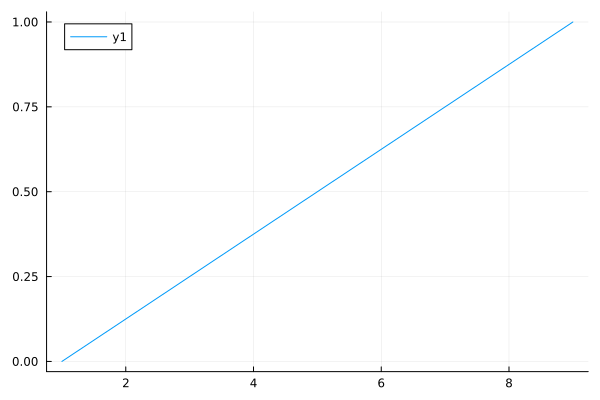

In [10]:
A[1,:] .= 0; A[1,1]= 1; 
A[end,:] .= 0; A[end,end] = 1; 
f = zeros(9); f[end] = 1; 
h = 1/4; 
u = A \ f; 
plot(u)

In [11]:
mesh = genMesh(10);
@code_warntype genStiffMat(mesh)

MethodInstance for genStiffMat(::Mesh)
  from genStiffMat(mesh::Mesh) in Main at In[8]:14
Arguments
  #self#::Core.Const(genStiffMat)
  mesh::Mesh
Locals
  @_3::Union{Nothing, Tuple{Int64, Int64}}
  A::SparseMatrixCSC{Float64, Int64}
  J::Vector{Int64}
  I::Vector{Int64}
  Avalues::Vector{Float64}
  dofs2::Int64
  dofs::Int64
  nelements::Int64
  @_11::Int64
  i::Int64
  irng::MutableRange{Int64, UnitRange{Int64}}
  Aloc::SVector{9, Float64}
  Jloc::SVector{9, Int64}
  Iloc::SVector{9, Int64}
  element::Element
Body::SparseMatrixCSC{Float64, Int64}
1 ─       Core.NewvarNode(:(A))
│         (nelements = Base.getproperty(mesh, :nelements))
│   %3  = Base.getproperty(mesh, :Elements)::Vector{Element}
│   %4  = Base.getindex(%3, 1)::Element
│         (dofs = Base.getproperty(%4, :dofPerElement))
│   %6  = dofs::Int64
│   %7  = Core.apply_type(Base.Val, 2)::Core.Const(Val{2})
│   %8  = (%7)()::Core.Const(Val{2}())
│         (dofs2 = Base.literal_pow(Main.:^, %6, %8))
│   %10 = (dofs2 * nele

In [12]:
# test function for number of allocations and CPU time
# observe how the number of memory allocations only depends midly on the mesh size
mesh = genMesh(10);    @time genStiffMat(mesh); # force function compilation 
mesh = genMesh(10);    @time genStiffMat(mesh); 
mesh = genMesh(100);   @time genStiffMat(mesh);
mesh = genMesh(1000);  @time genStiffMat(mesh); 
mesh = genMesh(10000); @time genStiffMat(mesh); 

  0.000017 seconds (14 allocations: 6.188 KiB)
  0.000008 seconds (14 allocations: 6.188 KiB)
  0.000017 seconds (14 allocations: 54.188 KiB)
  0.000097 seconds (21 allocations: 524.719 KiB)
  0.001128 seconds (24 allocations: 5.113 MiB)


### Section 2.3: Assemble Right-Hand Side Vector

In [19]:
fsource(x) = x*(x-1)

function genLocVec(element, sourceFct)
    area = element.area 
    Iloc = SVector(element.e1, element.e2, element.e3)
    floc = (area/6)*SVector(sourceFct(element.p1), 4*sourceFct(element.p2), sourceFct(element.p3))
    # floc = (area/6)*SVector(sourceFct(element.p1), sourceFct(element.p2), sourceFct(element.p3))
    return Iloc, floc
end

function genVector(mesh, sourceFct::F) where F 
    
    #..recover number of elements  
    nelements = mesh.nelements 
    nnodes = mesh.nnodes 
    
    #..initialize global vector  
    f = zeros(Float64,nnodes)

    for i = 1:nelements #..loop over number of elements..
        element = mesh.Elements[i]
        Iloc, floc = genLocVec(element,sourceFct) 
        f[Iloc] .+= floc          
    end
   
    return f; 
end

genVector (generic function with 1 method)

In [20]:
mesh = genMesh(4); 
#display(mesh)
#f = genVector(mesh,fsource);
#@code_warntype genVector(mesh, fsource)

In [21]:
# observe again how the number of memory allocations only depends midly on the mesh size
mesh = genMesh(10);    @time f = genVector(mesh,fsource); # force function compilation
mesh = genMesh(10);    @time f = genVector(mesh,fsource);
mesh = genMesh(100);   @time f = genVector(mesh,fsource);
mesh = genMesh(1000);  @time f = genVector(mesh,fsource);
mesh = genMesh(10000); @time f = genVector(mesh,fsource);

  0.145837 seconds (604.82 k allocations: 32.210 MiB, 99.97% compilation time)
  0.000003 seconds (1 allocation: 224 bytes)
  0.000001 seconds (1 allocation: 1.766 KiB)
  0.000004 seconds (1 allocation: 15.812 KiB)
  0.000027 seconds (2 allocations: 156.359 KiB)


## Section 4: Solve Process 

In [22]:
#..set exact solution with homogeneous Dirichlet boundary conditions on both sides.. 
#..fourth derivative is zero - three point difference scheme is exact 
uexactFct1(x) = x*(x-1)
uexactFct2(x) = sin(π*x)

#..set exact solution with homogeneous Dirichlet left and homogeneous Neumann on the right..  
#..fourth derivative is zero - three point difference scheme is exact 
uexactFct3(x) = -0.5*x*x + x 
uexactFct4(x) = sin(π/2*x)

#..set exact solution with periodic boundary conditions: equal values and equal normal derivatives..    
uexactFct5(x) = sin(2*π*x) 

#..set source function: observe the minus sign: f(x) = - u''(x).. 
#..(we would like to set f(x) automatically given u(x))..  
fsourceFct1(x) = -2
fsourceFct2(x) = π*π*sin(π*x)

fsourceFct3(x) = 1. 
fsourceFct4(x) = π^2/4*sin(π/2*x)

fsourceFct5(x) = (4*π*π+1)*sin(2*π*x)

fsourceFct5 (generic function with 1 method)

  0.000112 seconds (74 allocations: 163.078 KiB)


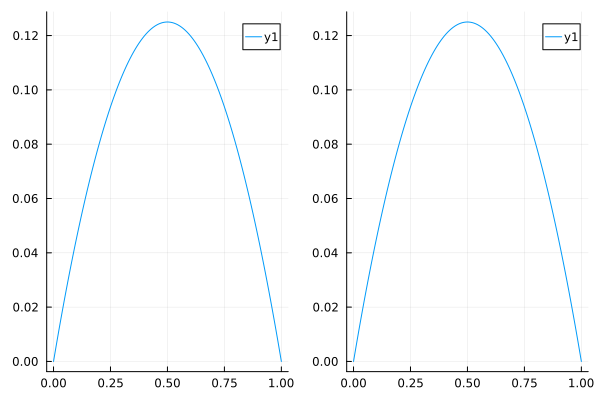

In [25]:
fsource(x) = 1 
uexact(x) = 0.5*x*x - .5*x 

N = 64
mesh = genMesh(N)

A = genStiffMat(mesh) # force compilation 
f = genVector(mesh,fsource) # force compilation

function genSolution(mesh, A,f)
    #..handle essential boundary conditions 
    A[1,:] .= 0; A[1,1] = 1.; f[1] = 0.;
    A[end,:] .= 0; A[end,end] = 1.; f[end] = 0.;
    u = A\f 
    return u, A, f 
end

u,_ = genSolution(mesh,A,f) # force compilation 
@time u,_ = genSolution(mesh,A,f)

p1 = plot(mesh.Nodes, u)
p2 = plot(mesh.Nodes, -uexact.(mesh.Nodes))

plot(p1,p2)

In [26]:
# observe again how the number of memory allocations only depends midly on the mesh size
# observe how assembly is much faster than the solve 
mesh = genMesh(10);    @time A = genStiffMat(mesh); f = genVector(mesh,fsource); 
@time u,_ = genSolution(mesh,A,f);
mesh = genMesh(100);   @time A = genStiffMat(mesh); f = genVector(mesh,fsource); 
@time u,_ = genSolution(mesh,A,f);
mesh = genMesh(1000);  @time A = genStiffMat(mesh); f = genVector(mesh,fsource); 
@time u,_ = genSolution(mesh,A,f);
mesh = genMesh(10000); @time A = genStiffMat(mesh); f = genVector(mesh,fsource); 
@time u,_ = genSolution(mesh,A,f);

  0.000018 seconds (15 allocations: 6.234 KiB)
  0.000087 seconds (74 allocations: 40.078 KiB)
  0.000021 seconds (15 allocations: 54.234 KiB)
  0.000161 seconds (74 allocations: 244.656 KiB)
  0.000111 seconds (22 allocations: 524.766 KiB)
  0.000870 seconds (76 allocations: 2.220 MiB)
  0.001108 seconds (25 allocations: 5.113 MiB)
  0.010264 seconds (80 allocations: 22.037 MiB)


## Section 6: Computing the Derivative

## Section 7: Mesh Refinement Study 
Check converge to both $u(x)$ and $du/dx$ as the mesh is refined.  

In [27]:
function genError(mesh, u, exactFct::F) where F 
    #..recover mesh nodes  
    nodes = mesh.Nodes
    
    #..set vector values using broadcasting (dot syntax)  
    ue = exactFct.(nodes)
    
    #..compute the error
    err = ue - u  
    
    #..compute error norm 
    errnrm = norm(err,Inf)
    
    return err, errnrm; 
end

genError (generic function with 1 method)

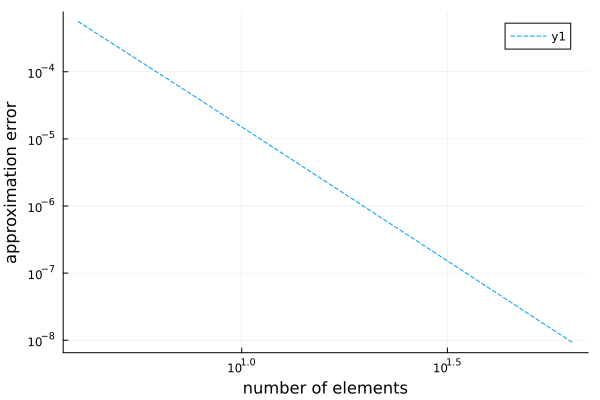

In [29]:
elementNumbers = [2^p for p in 2:6]
errnrm = zeros(length(elementNumbers)) 
err = Vector{Vector{Float64}}(undef,length(elementNumbers))

for (i,N) in enumerate(elementNumbers)
    mesh = genMesh(N);
    A = genStiffMat(mesh); 
    f = genVector(mesh,fsourceFct2); 
    u,_ = genSolution(mesh,A,f);
    err[i], errnrm[i] = genError(mesh, u, uexactFct2)
end 

plot(elementNumbers, errnrm, ls=:dash, xaxis=:log, yaxis=:log)
xlabel!("number of elements")
ylabel!("approximation error")

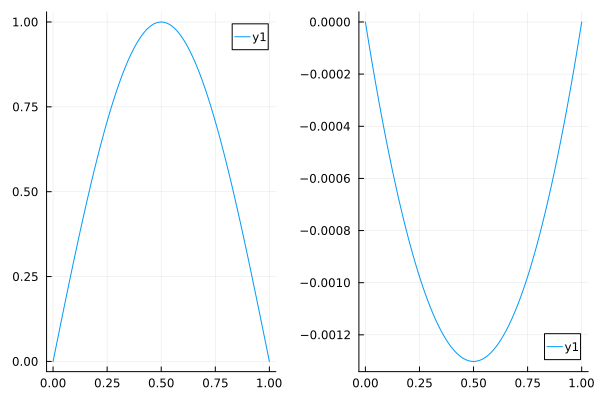

In [22]:
p1 = plot(mesh.Nodes,uexactFct2.(mesh.Nodes))
p2 = plot(mesh.Nodes,u)
plot(p1,p2)

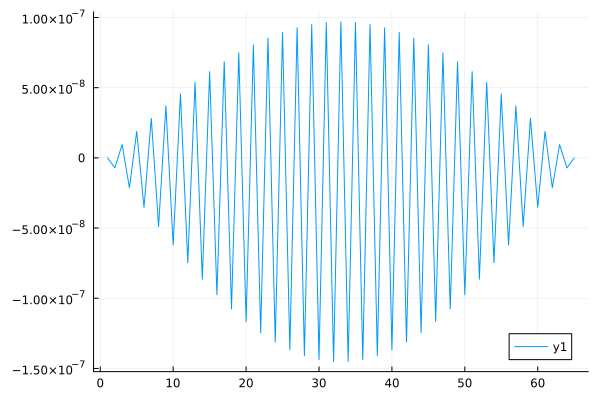

In [32]:
plot(err[4])

## Section 8: Variable Diffusion Coefficient 
We change the Poisson equation to ... 

## Section 9: Zeroth Order Derivative and Mass Matrix Term 

## Sandbox